In [272]:
#Mechanics of Learning

In [273]:
import torch

#temperature readings
#t_u is input, t_c is ground truth
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [274]:
#linear model
def model(t_u, w, b):
    return w*t_u + b

#loss square mean
def loss(t_p, t_c):
    squared_diff = (t_p-t_c)**2
    return squared_diff.mean()

In [275]:
# initialize w, b and get the initial loss
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [276]:
loss_in = loss(t_p, t_c)
loss_in

tensor(1763.8848)

In [277]:
#decrease loss by calculating gradient and moving in that direction
# manual gradient calculation, won't scale
delta = 0.1
loss_rate_of_change_w = (loss(model(t_u, w+delta, b),t_c) - loss(model(t_u, w-delta, b), t_c))/ (2.0 * delta)
loss_rate_of_change_w

tensor(4517.2974)

In [278]:
delta = 0.1
loss_rate_of_change_b = (loss(model(t_u, w, b+delta),t_c) - loss(model(t_u, w, b-delta), t_c))/ (2.0 * delta)
loss_rate_of_change_b

tensor(82.5995)

In [279]:
learning_rate = 1e-2
w = w - learning_rate * loss_rate_of_change_w
b = b - learning_rate * loss_rate_of_change_b
w, b

(tensor(-44.1730), tensor(-0.8260))

In [280]:
# compute derivates to updates weights 
# derivate of d_loss/d_w is d_loss/d_tp * d_tp/d_w same would apoly for b
# d_loss_d_tp = 
def dloss_dpred(t_p, t_c):
    return 2*(t_p-t_c) / t_p.shape[0]

def dpred_dw(t_u) :
    return t_u

def dpred_db() :
    return torch.tensor(1.0)


# make grads cleaner
def grad_fn(t_u, t_p, t_c):
    #print("Grads invoked")
    dloss_dtp = dloss_dpred(t_p, t_c)
    dloss_dw = dloss_dtp * dpred_dw(t_u)
    dloss_db = dloss_dtp * dpred_db()
    #sum is important in the following line as its a single weight being learnt
    # for both w and b, we are doing elementwise multiplication as its different data samples being used to 
    # estimate outputs not different features, hence no matmul is needed here and sum would give the cumulative output.
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

def grad_fn2(t_u, t_p, t_c):
    #print("Grads invoked")
    dloss_dtp = dloss_dpred(t_p, t_c)
    print("dloss_dtp shape", dloss_dtp.shape)
    #print("loss wrt pred", dloss_dtp)
    dloss_dw = dloss_dtp.unsqueeze(0) @ dpred_dw(t_u).unsqueeze(0).transpose(0,1)
    print("shape dloss_dtp.unsqueeze(0)", dloss_dtp.unsqueeze(0).shape)
    print("shape dpred_dw(t_u).unsqueeze(0).transpose(0,1)", dpred_dw(t_u).unsqueeze(0).transpose(0,1).shape)
    print("dloss_dw shape", dloss_dw.shape)
    print("dloss_dw", dloss_dw)
    print("shape dpred_db().unsqueeze(0) & dpred_db()", dpred_db().expand_as(dloss_dtp).shape, dpred_db().expand_as(dloss_dtp))
    dloss_db = dloss_dtp.unsqueeze(0) @ (dpred_db().unsqueeze(0).expand_as(dloss_dtp))
    print("dloss_dw shape",dloss_dw.squeeze().shape, dloss_dw.squeeze())
    print("dloss_db shpae", dloss_db.squeeze().shape, dloss_db.squeeze())
    return torch.stack([dloss_dw.squeeze(), dloss_db.squeeze()])

In [281]:
params = torch.tensor([1.0, 0.0])
w, b = params
pred = model(t_u, w, b)
los= loss(pred, t_c)
grads1 = grad_fn(t_u, pred, t_c)
grads2 = grad_fn2(t_u, pred, t_c)
print(grads1)
print(grads2)
        

dloss_dtp shape torch.Size([11])
shape dloss_dtp.unsqueeze(0) torch.Size([1, 11])
shape dpred_dw(t_u).unsqueeze(0).transpose(0,1) torch.Size([11, 1])
dloss_dw shape torch.Size([1, 1])
dloss_dw tensor([[4517.2969]])
shape dpred_db().unsqueeze(0) & dpred_db() torch.Size([11]) tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
dloss_dw shape torch.Size([]) tensor(4517.2969)
dloss_db shpae torch.Size([]) tensor(82.6000)
tensor([4517.2964,   82.6000])
tensor([4517.2969,   82.6000])


In [282]:
#now we have defined the gradient computation, we need to estimate parameters
# we can have a training run to repeated apply this

def training_loop(params, learning_rate, t_u, t_c, epochs):
    for i in range(epochs):
        w, b = params
        pred = model(t_u, w, b)
        los= loss(pred, t_c)
        grads = grad_fn(t_u, pred, t_c)
        if(i==0):
            print("grads shape", grads.shape)
        #update the params to reduce loss
        params = params - learning_rate * grads
        print('Epoch %s, loss %f' %(i, float(los)))
    return params


In [283]:
params = torch.tensor([1.0, 0.0])
learning_rate = 1e-2
epochs = 30
params = training_loop(params, learning_rate, t_u, t_c, epochs)
print(params)

grads shape torch.Size([2])
Epoch 0, loss 1763.884766
Epoch 1, loss 5802484.500000
Epoch 2, loss 19408029696.000000
Epoch 3, loss 64915905708032.000000
Epoch 4, loss 217130525461053440.000000
Epoch 5, loss 726257583152928129024.000000
Epoch 6, loss 2429183416467662896627712.000000
Epoch 7, loss 8125122549611731432050262016.000000
Epoch 8, loss 27176882120842590626938030653440.000000
Epoch 9, loss 90901105189019073810297959556841472.000000
Epoch 10, loss inf
Epoch 11, loss inf
Epoch 12, loss inf
Epoch 13, loss inf
Epoch 14, loss inf
Epoch 15, loss inf
Epoch 16, loss inf
Epoch 17, loss inf
Epoch 18, loss inf
Epoch 19, loss inf
Epoch 20, loss inf
Epoch 21, loss inf
Epoch 22, loss nan
Epoch 23, loss nan
Epoch 24, loss nan
Epoch 25, loss nan
Epoch 26, loss nan
Epoch 27, loss nan
Epoch 28, loss nan
Epoch 29, loss nan
tensor([nan, nan])


In [284]:
# as we can see loss has diverged and has expanded a loss, 
# this is typically a result of higher movements across the loss curve, we can make it slower via reduce learning rate

learning_rate = 1e-4
epochs = 5000
params = training_loop(torch.tensor([1.0, 0.0]), learning_rate, t_u, t_c, epochs)
print(params)

grads shape torch.Size([2])
Epoch 0, loss 1763.884766
Epoch 1, loss 323.090515
Epoch 2, loss 78.929634
Epoch 3, loss 37.552845
Epoch 4, loss 30.540283
Epoch 5, loss 29.351154
Epoch 6, loss 29.148884
Epoch 7, loss 29.113848
Epoch 8, loss 29.107145
Epoch 9, loss 29.105247
Epoch 10, loss 29.104168
Epoch 11, loss 29.103222
Epoch 12, loss 29.102295
Epoch 13, loss 29.101379
Epoch 14, loss 29.100466
Epoch 15, loss 29.099548
Epoch 16, loss 29.098631
Epoch 17, loss 29.097717
Epoch 18, loss 29.096796
Epoch 19, loss 29.095881
Epoch 20, loss 29.094959
Epoch 21, loss 29.094049
Epoch 22, loss 29.093134
Epoch 23, loss 29.092216
Epoch 24, loss 29.091301
Epoch 25, loss 29.090385
Epoch 26, loss 29.089464
Epoch 27, loss 29.088551
Epoch 28, loss 29.087635
Epoch 29, loss 29.086714
Epoch 30, loss 29.085804
Epoch 31, loss 29.084888
Epoch 32, loss 29.083967
Epoch 33, loss 29.083057
Epoch 34, loss 29.082142
Epoch 35, loss 29.081221
Epoch 36, loss 29.080309
Epoch 37, loss 29.079390
Epoch 38, loss 29.078474
Epoc

Epoch 3072, loss 26.442316
Epoch 3073, loss 26.441496
Epoch 3074, loss 26.440672
Epoch 3075, loss 26.439848
Epoch 3076, loss 26.439026
Epoch 3077, loss 26.438200
Epoch 3078, loss 26.437378
Epoch 3079, loss 26.436552
Epoch 3080, loss 26.435732
Epoch 3081, loss 26.434908
Epoch 3082, loss 26.434082
Epoch 3083, loss 26.433260
Epoch 3084, loss 26.432436
Epoch 3085, loss 26.431618
Epoch 3086, loss 26.430792
Epoch 3087, loss 26.429964
Epoch 3088, loss 26.429146
Epoch 3089, loss 26.428322
Epoch 3090, loss 26.427502
Epoch 3091, loss 26.426678
Epoch 3092, loss 26.425848
Epoch 3093, loss 26.425032
Epoch 3094, loss 26.424208
Epoch 3095, loss 26.423378
Epoch 3096, loss 26.422564
Epoch 3097, loss 26.421740
Epoch 3098, loss 26.420921
Epoch 3099, loss 26.420094
Epoch 3100, loss 26.419273
Epoch 3101, loss 26.418451
Epoch 3102, loss 26.417625
Epoch 3103, loss 26.416801
Epoch 3104, loss 26.415983
Epoch 3105, loss 26.415155
Epoch 3106, loss 26.414330
Epoch 3107, loss 26.413515
Epoch 3108, loss 26.412691
E

In [285]:
#nice, the loss is table now but it decreases pretty slowly and has stalled, to solve this we need to make learning rate adaptive
# we'll see that soon on how to fix that. 

# Another issue is that, if we look at the gradients initially (tensor([4517.2964,   82.6000])),
# they live in pretty different scale (2 orders of magnitude apart), 
#this means that a learning rate enough for one will be either too large or too small for the other one. 
# we can have different learning rates but it becomes hard to manage and scale
# hence to solve this and make gradients in similar scale we need to scale the inputs between [-1.0, 1.0], normalization
#normalizing inputs
t_un = 0.1 * t_u

# let it run for a large number of epochs
params = training_loop(torch.tensor([1.0, 0.0]), 1e-2, t_un, t_c, 5000)

grads shape torch.Size([2])
Epoch 0, loss 80.364342
Epoch 1, loss 37.574913
Epoch 2, loss 30.871077
Epoch 3, loss 29.756193
Epoch 4, loss 29.507153
Epoch 5, loss 29.392456
Epoch 6, loss 29.298828
Epoch 7, loss 29.208717
Epoch 8, loss 29.119415
Epoch 9, loss 29.030489
Epoch 10, loss 28.941877
Epoch 11, loss 28.853565
Epoch 12, loss 28.765553
Epoch 13, loss 28.677851
Epoch 14, loss 28.590431
Epoch 15, loss 28.503319
Epoch 16, loss 28.416498
Epoch 17, loss 28.329973
Epoch 18, loss 28.243742
Epoch 19, loss 28.157804
Epoch 20, loss 28.072151
Epoch 21, loss 27.986797
Epoch 22, loss 27.901728
Epoch 23, loss 27.816950
Epoch 24, loss 27.732464
Epoch 25, loss 27.648256
Epoch 26, loss 27.564344
Epoch 27, loss 27.480707
Epoch 28, loss 27.397362
Epoch 29, loss 27.314295
Epoch 30, loss 27.231512
Epoch 31, loss 27.149010
Epoch 32, loss 27.066790
Epoch 33, loss 26.984844
Epoch 34, loss 26.903175
Epoch 35, loss 26.821791
Epoch 36, loss 26.740679
Epoch 37, loss 26.659838
Epoch 38, loss 26.579279
Epoch 3

Epoch 523, loss 7.473566
Epoch 524, loss 7.458135
Epoch 525, loss 7.442750
Epoch 526, loss 7.427427
Epoch 527, loss 7.412152
Epoch 528, loss 7.396928
Epoch 529, loss 7.381757
Epoch 530, loss 7.366637
Epoch 531, loss 7.351567
Epoch 532, loss 7.336549
Epoch 533, loss 7.321584
Epoch 534, loss 7.306671
Epoch 535, loss 7.291804
Epoch 536, loss 7.276989
Epoch 537, loss 7.262227
Epoch 538, loss 7.247512
Epoch 539, loss 7.232845
Epoch 540, loss 7.218231
Epoch 541, loss 7.203665
Epoch 542, loss 7.189151
Epoch 543, loss 7.174683
Epoch 544, loss 7.160266
Epoch 545, loss 7.145897
Epoch 546, loss 7.131581
Epoch 547, loss 7.117305
Epoch 548, loss 7.103083
Epoch 549, loss 7.088911
Epoch 550, loss 7.074785
Epoch 551, loss 7.060707
Epoch 552, loss 7.046676
Epoch 553, loss 7.032695
Epoch 554, loss 7.018755
Epoch 555, loss 7.004870
Epoch 556, loss 6.991028
Epoch 557, loss 6.977232
Epoch 558, loss 6.963488
Epoch 559, loss 6.949787
Epoch 560, loss 6.936135
Epoch 561, loss 6.922528
Epoch 562, loss 6.908967


Epoch 4632, loss 2.927651
Epoch 4633, loss 2.927650
Epoch 4634, loss 2.927650
Epoch 4635, loss 2.927650
Epoch 4636, loss 2.927649
Epoch 4637, loss 2.927650
Epoch 4638, loss 2.927650
Epoch 4639, loss 2.927649
Epoch 4640, loss 2.927650
Epoch 4641, loss 2.927649
Epoch 4642, loss 2.927650
Epoch 4643, loss 2.927650
Epoch 4644, loss 2.927649
Epoch 4645, loss 2.927649
Epoch 4646, loss 2.927650
Epoch 4647, loss 2.927650
Epoch 4648, loss 2.927649
Epoch 4649, loss 2.927650
Epoch 4650, loss 2.927649
Epoch 4651, loss 2.927650
Epoch 4652, loss 2.927651
Epoch 4653, loss 2.927650
Epoch 4654, loss 2.927650
Epoch 4655, loss 2.927651
Epoch 4656, loss 2.927650
Epoch 4657, loss 2.927651
Epoch 4658, loss 2.927650
Epoch 4659, loss 2.927649
Epoch 4660, loss 2.927649
Epoch 4661, loss 2.927648
Epoch 4662, loss 2.927649
Epoch 4663, loss 2.927648
Epoch 4664, loss 2.927648
Epoch 4665, loss 2.927649
Epoch 4666, loss 2.927649
Epoch 4667, loss 2.927649
Epoch 4668, loss 2.927649
Epoch 4669, loss 2.927650
Epoch 4670, 

In [286]:
#nice we can see that the loss is much lesser now.
#Note: The learning rate was increased otherwise we won't see faster convergence, but the interesting thing is
# that the loss didn;t diverge as initially since the inputs were scale. 
# have not increased the learning rate the loss won't converge faster.
#In a nutshell normalizing inputs helped us pick a larger learning rate, leading to lower loss faster, safeguarding againt divergence.
print(params)
#params pretty close to the fareinheit to celsius conversion.

tensor([  5.3671, -17.3012])


In [287]:
pip install matplotlib


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


torch.Size([11])
torch.Size([11])
[35.7 55.9 58.2 81.9 56.3 48.9 33.9 21.8 48.4 60.4 68.4]
[ 1.8593006 12.700808  13.935238  26.655228  12.915491   8.943851
  0.8932247 -5.6009474  8.675495  15.115997  19.409664 ]


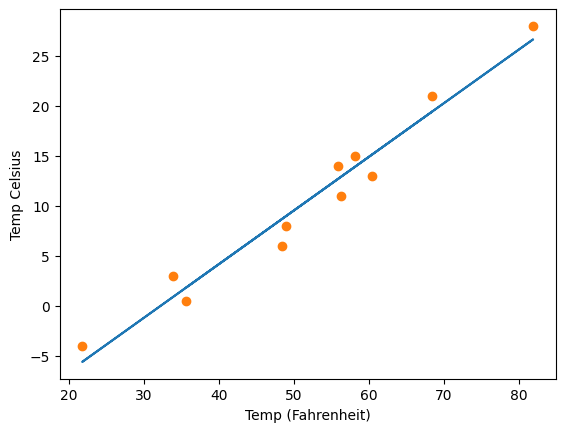

In [292]:
#visualize the data now

from matplotlib import pyplot as plt
t_p = model(t_un, *params)
print(t_u.shape)
print(t_p.shape)
print(t_u.numpy())
print(t_p.detach().numpy())
fig = plt.figure()
plt.xlabel("Temp (Fahrenheit)")
plt.ylabel("Temp Celsius")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')



In [293]:
#Lets start using pytorch autograd instead of doing htings manually

In [302]:
def model(t_u, w, b):
    return t_u*w + b

def loss_fn(t_p, t_c):
    return torch.mean((t_p - t_c)**2)


params = torch.tensor([1.0, 0.0], requires_grad=True)
#Note we made the requires_grad param True this makes autograd start tracking the tensor and any descendants
print("params.grad is None:", params.grad is None)

params.grad is None: True


In [303]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward() # This triggers the automatic backward computation

In [305]:
params.grad # Note these does match with inital grads that we got manually

tensor([4517.2969,   82.6000])

In [306]:
if params.grad is not None:
    params.grad.zero_() # need to zero out gradients after each iter, since the accumulate by default

In [314]:
def training_loop(t_u, t_c, params, learning_rate, epochs):
    for i in range(epochs):
        t_p = model(t_u, *params)
        if(params.grad is not None):# reset grads to zero to clean up prev grads
            params.grad.zero_()
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
        with torch.no_grad():
            params -= learning_rate* params.grad
            
        if(i%500 ==0):
            print(f"Epoch {i}th loss is {loss}")
    return params

In [315]:
params = training_loop(t_un, t_c, torch.tensor([1.0, 0.0], requires_grad=True), 1e-2, 5000)

Epoch 0th loss is 80.36434173583984
Epoch 500th loss is 7.843369007110596
Epoch 1000th loss is 3.8254828453063965
Epoch 1500th loss is 3.091630458831787
Epoch 2000th loss is 2.9575960636138916
Epoch 2500th loss is 2.9331159591674805
Epoch 3000th loss is 2.9286458492279053
Epoch 3500th loss is 2.9278290271759033
Epoch 4000th loss is 2.9276793003082275
Epoch 4500th loss is 2.927651882171631


In [316]:
params

tensor([  5.3671, -17.3012], requires_grad=True)

In [318]:
#nice so we have automated the grad computation
#moving forward can we take care of optimization automatically
import torch.optim as optim
dir(optim)

['ASGD',
 'Adadelta',
 'Adafactor',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_adafactor',
 '_functional',
 'lr_scheduler',
 'swa_utils']

In [328]:
#update params via optimizer step
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], learning_rate)
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()
optimizer.step()
params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

In [330]:
#clear out params using optimizer zero grad to stop accumulating
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], learning_rate)
optimizer.zero_grad()
t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)
loss.backward()
optimizer.step()
params
#helped us abstract away the logic of optimizer

tensor([1.7761, 0.1064], requires_grad=True)

In [343]:
#ok now we can update teh trianing loop  to use the optimizer
def training_loop(t_u, t_c, params, optimizer, epochs):
    for i in range(epochs):
        t_p = model(t_u, *params)
        #clear out the grads
        optimizer.zero_grad()
        loss = loss_fn(t_p, t_c)
        loss.backward()
        #take optim step
        optimizer.step()
            
        if(i%500 ==0):
            print(f"Epoch {i}th loss is {loss}")
    return params

In [344]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
optimizer = optim.SGD([params], 1e-2)
params = training_loop(t_un, t_c, params, optimizer, 5000)
print(params)

Epoch 0th loss is 80.36434173583984
Epoch 500th loss is 7.843376636505127
Epoch 1000th loss is 3.8254828453063965
Epoch 1500th loss is 3.091630458831787
Epoch 2000th loss is 2.9575960636138916
Epoch 2500th loss is 2.9331159591674805
Epoch 3000th loss is 2.9286458492279053
Epoch 3500th loss is 2.9278290271759033
Epoch 4000th loss is 2.9276793003082275
Epoch 4500th loss is 2.927651882171631
tensor([  5.3671, -17.3012], requires_grad=True)


In [345]:
#using more sophisticated Optimizer like Adam
params = torch.tensor([1.0, 0.0], requires_grad=True)
optimizer = optim.Adam([params], lr=0.1)
#So using Adam since it is more advanced due to momentum and rmsprop baked in, 
# we can make it more challenging and it'll still work
# by using raw unnormalized inputs and higher learning rate. 
params = training_loop(t_u, t_c, params, optimizer, 5000) # note: used t_u isntead of t_un and lr =1e-1 even faster
print(params)

Epoch 0th loss is 1763.884765625
Epoch 500th loss is 7.5888752937316895
Epoch 1000th loss is 3.085365056991577
Epoch 1500th loss is 2.928568124771118
Epoch 2000th loss is 2.9276459217071533
Epoch 2500th loss is 2.927645206451416
Epoch 3000th loss is 2.9276459217071533
Epoch 3500th loss is 2.927644968032837
Epoch 4000th loss is 2.927645683288574
Epoch 4500th loss is 2.927645683288574
tensor([  0.5368, -17.3048], requires_grad=True)


In [348]:
#lets now introduce the validation set concept to track the real performance
n_samples = t_u.shape[0]
n_val = int(0.2* n_samples)
print(f"n_samples: {n_samples}, n_val: {n_val}")
perm_indices = torch.randperm(n_samples)
train_indices = perm_indices[:-n_val]
val_indices = perm_indices[-n_val:]

tu_train = t_u[train_indices]
tc_train = t_c[train_indices]
print("tu_train:", tu_train)
tu_val = t_u[val_indices]
tc_val = t_c[val_indices]
print("tu_val:", tu_val)


n_samples: 11, n_val: 2
tu_train: tensor([81.9000, 33.9000, 56.3000, 68.4000, 55.9000, 60.4000, 58.2000, 35.7000,
        48.4000])
tu_val: tensor([21.8000, 48.9000])


In [362]:
#updated training loop with val loss also produced and different datasets
def training_loop(tu_train, tc_train, tu_val, tc_val, params, optimizer, epochs):
    for i in range(epochs):
        #clear out the grads
        optimizer.zero_grad()
        
        tp_train = model(tu_train, *params)
        loss_train = loss_fn(tp_train, tc_train)
        tp_val = model(tu_val, *params)
        loss_val = loss_fn(tp_val, tc_val)
        #assert loss_val.requires_grad == False, this assertion would fail here since the graph exists due to params having set the requires_Grad = true
        loss_train.backward()
        #take optim step
        optimizer.step()
        
        if(i <3 or i%500 ==0):
            print(f"Epoch {i}th train loss is {loss_train}, val loss is {loss_val}")
    return params

In [363]:
init_params = torch.tensor([1.0, 0.0], requires_grad=True)
learned_params = training_loop(tu_train, tc_train, tu_val, tc_val, init_params, optim.Adam([init_params], lr=0.1), 5000)
print(learned_params)

Epoch 0th train loss is 1896.03125, val loss is 1169.22509765625
Epoch 1th train loss is 1426.12451171875, val loss is 921.3591918945312
Epoch 2th train loss is 1026.307373046875, val loss is 704.876953125
Epoch 500th train loss is 9.689230918884277, val loss is 11.08199691772461
Epoch 1000th train loss is 3.7281429767608643, val loss is 0.9117413759231567
Epoch 1500th train loss is 3.069870948791504, val loss is 2.7164382934570312
Epoch 2000th train loss is 3.0480682849884033, val loss is 3.4578757286071777
Epoch 2500th train loss is 3.0478899478912354, val loss is 3.5353851318359375
Epoch 3000th train loss is 3.0478899478912354, val loss is 3.5383362770080566
Epoch 3500th train loss is 3.047889471054077, val loss is 3.5383715629577637
Epoch 4000th train loss is 3.047889471054077, val loss is 3.538393497467041
Epoch 4500th train loss is 3.0478899478912354, val loss is 3.5384140014648438
tensor([  0.5632, -18.8462], requires_grad=True)


In [364]:
#since val loss is not used to do back prop, we don't need the comp graph for it.
# update the loop

#updated training loop with val loss also produced and different datasets
def training_loop(tu_train, tc_train, tu_val, tc_val, params, optimizer, epochs):
    for i in range(epochs):

        tp_train = model(tu_train, *params)
        loss_train = loss_fn(tp_train, tc_train)
        assert loss_train.requires_grad == True
        
        with torch.no_grad():
            tp_val = model(tu_val, *params)
            loss_val = loss_fn(tp_val, tc_val)
            assert loss_val.requires_grad == False # validate the requires_grad is false for this

        #clear out the grads
        optimizer.zero_grad()
        loss_train.backward()
        #take optim step
        optimizer.step()
        
        if(i <3 or i%500 ==0):
            print(f"Epoch {i}th train loss is {loss_train}, val loss is {loss_val}")
    return params

In [365]:
init_params = torch.tensor([1.0, 0.0], requires_grad=True)
learned_params = training_loop(tu_train, tc_train, tu_val, tc_val, init_params, optim.Adam([init_params], lr=0.1), 5000)
print(learned_params)

Epoch 0th train loss is 1896.03125, val loss is 1169.22509765625
Epoch 1th train loss is 1426.12451171875, val loss is 921.3591918945312
Epoch 2th train loss is 1026.307373046875, val loss is 704.876953125
Epoch 500th train loss is 9.689230918884277, val loss is 11.08199691772461
Epoch 1000th train loss is 3.7281429767608643, val loss is 0.9117413759231567
Epoch 1500th train loss is 3.069870948791504, val loss is 2.7164382934570312
Epoch 2000th train loss is 3.0480682849884033, val loss is 3.4578757286071777
Epoch 2500th train loss is 3.0478899478912354, val loss is 3.5353851318359375
Epoch 3000th train loss is 3.0478899478912354, val loss is 3.5383362770080566
Epoch 3500th train loss is 3.047889471054077, val loss is 3.5383715629577637
Epoch 4000th train loss is 3.047889471054077, val loss is 3.538393497467041
Epoch 4500th train loss is 3.0478899478912354, val loss is 3.5384140014648438
tensor([  0.5632, -18.8462], requires_grad=True)


In [370]:
def calc_forward(tu, tc, params, is_train):
    with torch.set_grad_enabled(is_train):
        tp = model(tu, *params)
        loss = loss_fn(tp, tc)
    return loss

In [371]:
#since val loss is not used to do back prop, we don't need the comp graph for it.
# update the loop

#updated training loop with val loss also produced and different datasets
def training_loop(tu_train, tc_train, tu_val, tc_val, params, optimizer, epochs):
    for i in range(epochs):

        loss_train = calc_forward(tu_train, tc_train, params, True)
        assert loss_train.requires_grad == True
        
        with torch.no_grad():
            loss_val = calc_forward(tu_val, tc_val, params, False)
            assert loss_val.requires_grad == False # validate the requires_grad is false for this

        #clear out the grads
        optimizer.zero_grad()
        loss_train.backward()
        #take optim step
        optimizer.step()
        
        if(i <3 or i%500 ==0):
            print(f"Epoch {i}th train loss is {loss_train}, val loss is {loss_val}")
    return params

In [372]:
init_params = torch.tensor([1.0, 0.0], requires_grad=True)
learned_params = training_loop(tu_train, tc_train, tu_val, tc_val, init_params, optim.Adam([init_params], lr=0.1), 5000)
print(learned_params)

Epoch 0th train loss is 1896.03125, val loss is 1169.22509765625
Epoch 1th train loss is 1426.12451171875, val loss is 921.3591918945312
Epoch 2th train loss is 1026.307373046875, val loss is 704.876953125
Epoch 500th train loss is 9.689230918884277, val loss is 11.08199691772461
Epoch 1000th train loss is 3.7281429767608643, val loss is 0.9117413759231567
Epoch 1500th train loss is 3.069870948791504, val loss is 2.7164382934570312
Epoch 2000th train loss is 3.0480682849884033, val loss is 3.4578757286071777
Epoch 2500th train loss is 3.0478899478912354, val loss is 3.5353851318359375
Epoch 3000th train loss is 3.0478899478912354, val loss is 3.5383362770080566
Epoch 3500th train loss is 3.047889471054077, val loss is 3.5383715629577637
Epoch 4000th train loss is 3.047889471054077, val loss is 3.538393497467041
Epoch 4500th train loss is 3.0478899478912354, val loss is 3.5384140014648438
tensor([  0.5632, -18.8462], requires_grad=True)


In [376]:
#excersice , lets redefine the model now. 
#model needs tp be w2*t_u**2 + w1*t_u +b
#so quadratic model basically



#what part sof trainin loop and others we need to modify nothing much just update hte model and rest should work out of the box

def model2(t_u, w1, w2, b):
    return w2*(t_u**2) + w1*t_u + b


# rest of the code remains same as before , just copying here to refer to model2
#only changed to model2
def calc_forward(tu, tc, params, is_train):
    with torch.set_grad_enabled(is_train):
        tp = model2(tu, *params) 
        loss = loss_fn(tp, tc)
    return loss

#same as before
def training_loop(tu_train, tc_train, tu_val, tc_val, params, optimizer, epochs):
    for i in range(epochs):

        loss_train = calc_forward(tu_train, tc_train, params, True)
        assert loss_train.requires_grad == True
        
        with torch.no_grad():
            loss_val = calc_forward(tu_val, tc_val, params, False)
            assert loss_val.requires_grad == False # validate the requires_grad is false for this

        #clear out the grads
        optimizer.zero_grad()
        loss_train.backward()
        #take optim step
        optimizer.step()
        
        if(i <3 or i%500 ==0):
            print(f"Epoch {i}th train loss is {loss_train}, val loss is {loss_val}")
    return params

#update init_params to have w2 as well
init_params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learned_params = training_loop(tu_train, tc_train, tu_val, tc_val, init_params, optim.Adam([init_params], lr=0.1), 5000)
print(learned_params)

Epoch 0th train loss is 13626445.0, val loss is 3083100.25
Epoch 1th train loss is 11027099.0, val loss is 2495476.75
Epoch 2th train loss is 8711654.0, val loss is 1971975.25
Epoch 500th train loss is 3.8793013095855713, val loss is 11.529857635498047
Epoch 1000th train loss is 3.289371967315674, val loss is 8.919400215148926
Epoch 1500th train loss is 3.0662174224853516, val loss is 7.258942604064941
Epoch 2000th train loss is 3.021149158477783, val loss is 6.494593620300293
Epoch 2500th train loss is 3.0138916969299316, val loss is 6.219976902008057
Epoch 3000th train loss is 3.009424924850464, val loss is 6.119257926940918
Epoch 3500th train loss is 3.003870964050293, val loss is 6.046982288360596
Epoch 4000th train loss is 2.9967803955078125, val loss is 5.961859226226807
Epoch 4500th train loss is 2.9877946376800537, val loss is 5.854308605194092
tensor([-0.0732,  0.0055, -1.6550], requires_grad=True)


torch.Size([11])
torch.Size([11])
[35.7 55.9 58.2 81.9 56.3 48.9 33.9 21.8 48.4 60.4 68.4]
[ 2.7928295 11.566575  12.8523245 29.515614  11.785973   8.014162
  2.2304425 -0.6180742  7.7811966 14.137029  19.260841 ]


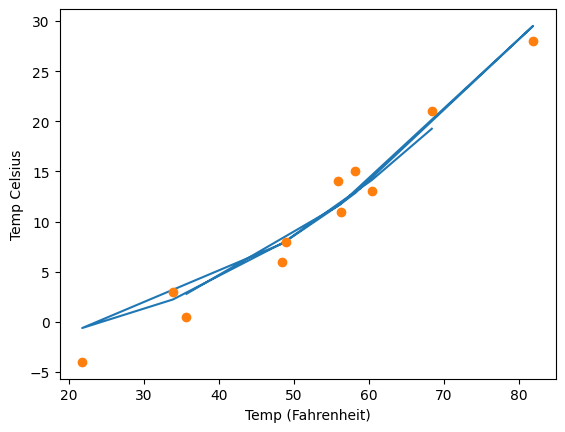

In [377]:
#interesting as we can see as compared to the previous run the model has lesser train loss but more validation loss
#we can see the model is overfitting
#lets plot. 


#visualize the data now

from matplotlib import pyplot as plt
t_p = model2(t_u, *learned_params)
print(t_u.shape)
print(t_p.shape)
print(t_u.numpy())
print(t_p.detach().numpy())
fig = plt.figure()
plt.xlabel("Temp (Fahrenheit)")
plt.ylabel("Temp Celsius")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
